# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Given the known salary for a big set of Job ID listings along with some known (relevant) features, i.e. Company ID, Job Type, Degree, Major, Industry, Years Experience, and Distance from Metropolitan, we would would like to develop a machine learned statistical model to predict the salary for another dataset of Job ID postings with the same features as the ones for jobs having known salaries. In other words, we train our model based on the Job ID dataset with known salaries and, then, test it on the Job ID dataset with unknown salaries. This is a supervised machine learning problem for lots of applications like glassdoor in order to predict salary for any given Job ID, e.g. position.

In [2]:
# Import the neccessary modules for data manipulation, visual representation, and machine learning algorithms
import numpy as np

import scipy as sp
from scipy.sparse import csr_matrix, hstack

import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures, LabelBinarizer, Binarizer, StandardScaler
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, BayesianRidge, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans

from xgboost import XGBClassifier

import seaborn as sns
import random
import math
import time
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#your info here
__author__ = "Ashoordin Ashoormaram"
__email__ = "a.ashoormaram@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----
Import the data (make sure you update this on a daily basis if applicable for the corresponding business problem)

In [3]:
#load the data into a Pandas dataframe
#training data
train_features = pd.read_csv('data/train_features.csv')
train_salaries = pd.read_csv('data/train_salaries.csv')

#testing data
test = pd.read_csv('data/test_features.csv')

In [4]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [5]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [6]:
train = pd.merge(train_features, train_salaries, on='jobId')

In [7]:
# Examine the dataset
train.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


### ---- 3 Clean the data ----

In [31]:
# Check to see if there is any missing data in the dataset
train.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [9]:
# Check the type of our features. Are there any data inconsistencies?
train.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [10]:
# look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

#Check to see if there are any missing values in our dataset
train.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
salary                 False
dtype: bool

In [11]:
#Check for duplicate data
train.duplicated().any()

False

In [15]:
#Check for invalid data (salaries <=0)
invalid_salary = sum(n <= 0 for n in train.salary)
print("invalid_salary:", invalid_salary)

#Check for invalid data (milesFromMetropolis <0)
invalid_milesFromMetropolis = sum(n < 0 for n in train.milesFromMetropolis)
print("invalid_milesFromMetropolis:", invalid_milesFromMetropolis)

#Check for invalid data (yearsExperience <0)
invalid_yearsExperience = sum(n < 0 for n in train.yearsExperience)
print("invalid_yearsExperience:", invalid_yearsExperience)

invalid_salary: 5
invalid_milesFromMetropolis: 0
invalid_yearsExperience: 0


In [14]:
#Check those data with 0 values of salaries
#query = 0
train.query('salary == %d' %0)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [30]:
#what fraction of data have "NONE" jobId
jobId_none = sum(n=='NONE' for n in train.jobId)
print("jobId_none:", jobId_none)

#what fraction of data have "NONE" companyId
companyId_none = sum(n=='NONE' for n in train.companyId)
print("companyId_none:", companyId_none)

#what fraction of data have "NONE" jobType
jobType_none = sum(n=='NONE' for n in train.jobType)
print("jobType_none:", jobType_none)

#what fraction of data have "NONE" degree
degree_none = sum(n=='NONE' for n in train.degree)
print("degree_none:", degree_none)

#what fraction of data have "NONE" majors
major_none = sum(n=='NONE' for n in train.major)
print("major_none:", major_none)

#what fraction of data have "NONE" industry
industry_none = sum(n=='NONE' for n in train.industry)
print("industry_none:", industry_none)

jobId_none: 0
companyId_none: 0
jobType_none: 0
degree_none: 236854
major_none: 532355
industry_none: 0


In [32]:
# Get names of indexes for which column salary has value 0
indexNames = train[ train['salary'] == 0 ].index

# Delete these row indexes from dataFrame
train_data = train.copy()
train_data.drop(indexNames, inplace=True)
print(train_data.shape)

(999995, 9)


### ---- 4 Explore the data (EDA) ----

In [3]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

In [145]:
# Finding count of distinct elements in DataFrame in each feature and target
train_data.nunique()

jobId                  999995
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    279
dtype: int64

In [149]:
# Showing distinct elements in DataFrame in each feature and target
companyId_uniqueValues = train_data['companyId'].unique()
jobType_uniqueValues = train_data['jobType'].unique()
degree_uniqueValues = train_data['degree'].unique()
major_uniqueValues = train_data['major'].unique()
industry_uniqueValues = train_data['industry'].unique()
yearsExperience_uniqueValues = train_data['yearsExperience'].unique()
milesFromMetropolis_uniqueValues = train_data['milesFromMetropolis'].unique()
salary_uniqueValues = train_data['salary'].unique()

print('companyId_uniqueValues:\n', companyId_uniqueValues)
print('\n')
print('jobType_uniqueValues:\n', jobType_uniqueValues)
print('\n')
print('degree_uniqueValues:\n', degree_uniqueValues)
print('\n')
print('major_uniqueValues:\n', major_uniqueValues)
print('\n')
print('industry_uniqueValues:\n', industry_uniqueValues)
print('\n')
print('yearsExperience_uniqueValues:\n', yearsExperience_uniqueValues)
print('\n')
print('salary_uniqueValues:\n', salary_uniqueValues)

companyId_uniqueValues:
 ['COMP37' 'COMP19' 'COMP52' 'COMP38' 'COMP7' 'COMP15' 'COMP24' 'COMP20'
 'COMP41' 'COMP56' 'COMP4' 'COMP54' 'COMP57' 'COMP14' 'COMP61' 'COMP58'
 'COMP3' 'COMP44' 'COMP30' 'COMP27' 'COMP34' 'COMP11' 'COMP31' 'COMP49'
 'COMP0' 'COMP1' 'COMP36' 'COMP47' 'COMP8' 'COMP42' 'COMP50' 'COMP53'
 'COMP48' 'COMP45' 'COMP46' 'COMP2' 'COMP5' 'COMP55' 'COMP29' 'COMP40'
 'COMP33' 'COMP22' 'COMP12' 'COMP25' 'COMP6' 'COMP23' 'COMP17' 'COMP28'
 'COMP21' 'COMP26' 'COMP43' 'COMP51' 'COMP10' 'COMP59' 'COMP13' 'COMP39'
 'COMP16' 'COMP9' 'COMP32' 'COMP62' 'COMP35' 'COMP18' 'COMP60']


jobType_uniqueValues:
 ['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']


degree_uniqueValues:
 ['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']


major_uniqueValues:
 ['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']


industry_uniqueValues:
 ['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']


yearsExperience_uni

In [34]:
# Summarize statistical description of numerical features
train_data.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


yearsExperience            AxesSubplot(0.08,0.125;0.255882x0.755)
milesFromMetropolis    AxesSubplot(0.387059,0.125;0.255882x0.755)
salary                 AxesSubplot(0.694118,0.125;0.255882x0.755)
dtype: object

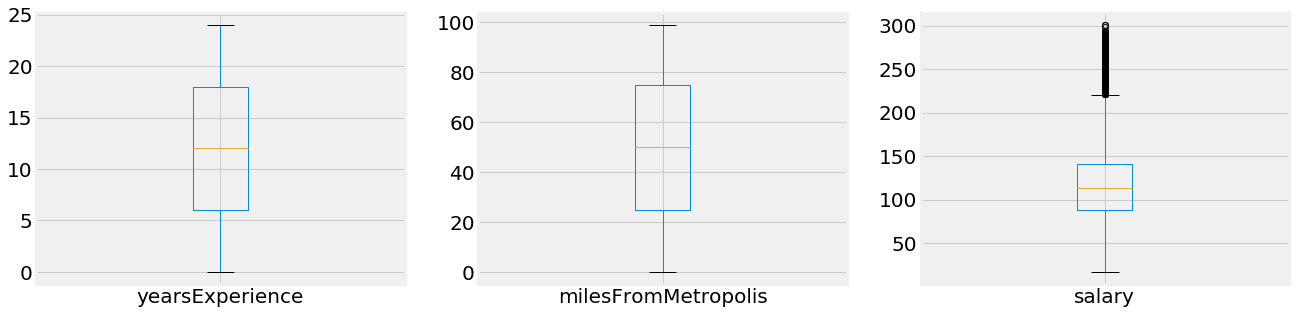

In [48]:
# Box and Whisker Plots
train_data.plot(kind='box', subplots=True, layout=(1,3), sharex=False, sharey=False, figsize=(20,5), fontsize=20)
plt.show()

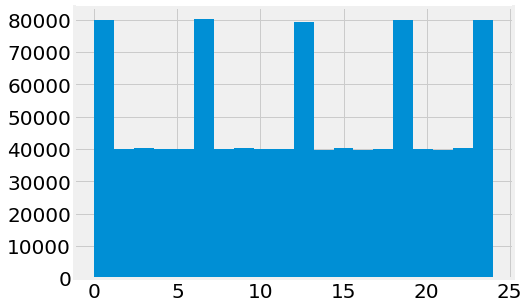

In [97]:
# Histogram Plots of yearsExperience
train_data.yearsExperience.hist(bins=20, figsize=(7,5), xlabelsize=20, ylabelsize=20)

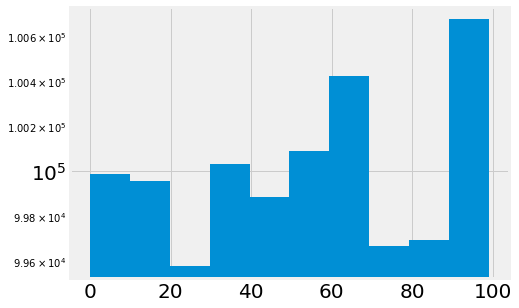

In [133]:
# Histogram Plots of milesFromMetropolis
train_data.milesFromMetropolis.hist(bins=10, figsize=(7,5), xlabelsize=20, ylabelsize=20, log=True)

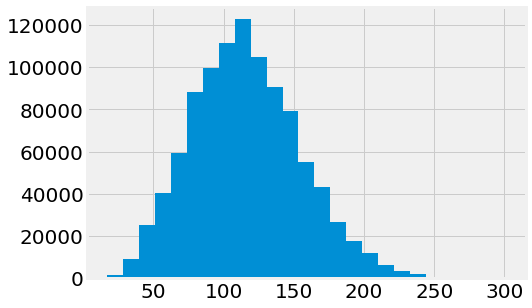

In [140]:
# Histogram Plots of salary
train_data.salary.hist(bins=25, figsize=(7,5), xlabelsize=20, ylabelsize=20)

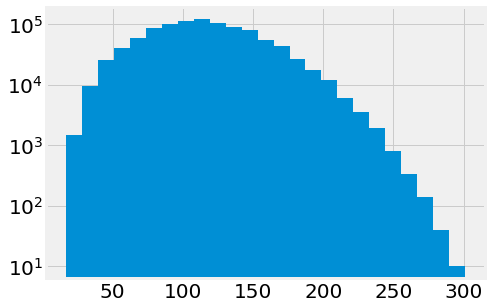

In [142]:
salary_log = train_data.salary
fig, ax = plt.subplots()
salary_log.hist(ax=ax, bins=25, figsize=(7,5), xlabelsize=20, ylabelsize=20)
ax.set_yscale('log')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8ae019350>,
      dtype=object)

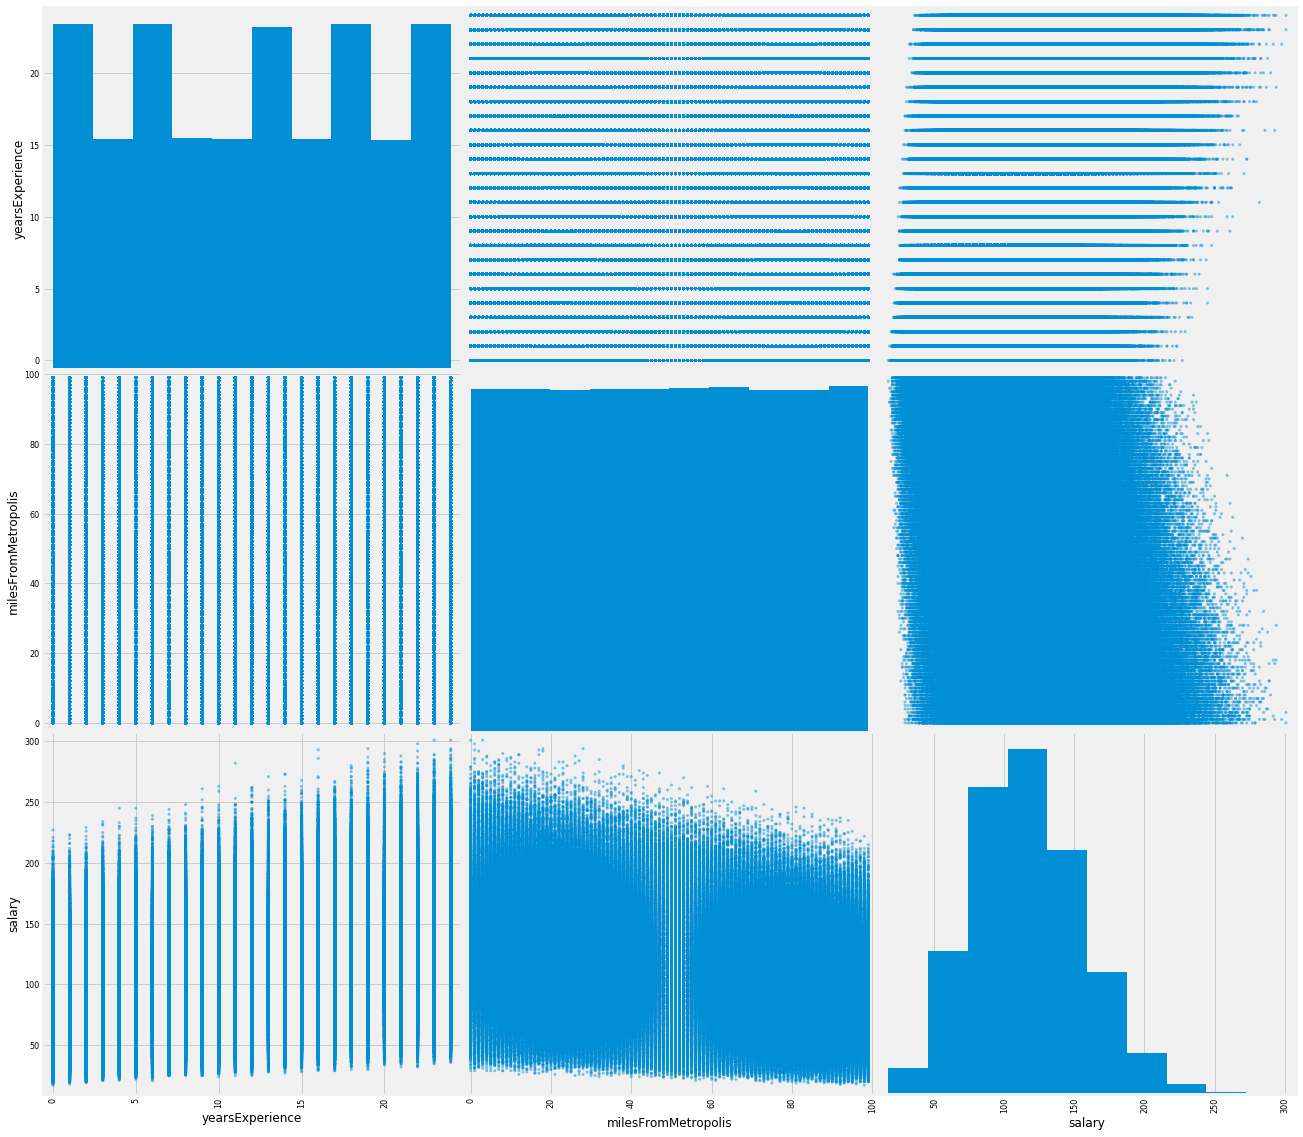

In [144]:
scatter_matrix(train_data, figsize=(20,20))
plt.show()

### ---- 5 Establish a baseline ----

In [5]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data